<center><h1>Patel_Deepkumar_FinalProject</h1></center>

Name: Deepkumar Patel
<br>
Github Username: deeppatel618
<br>
USC ID: 6771414477

In [2]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
import warnings
warnings.filterwarnings('ignore')

/Users/deeppatel/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Data Exploration and Pre-processing

In [11]:
# I have used various online resources to complete the final project
def load_and_process_text_data(base_directory):
    data_train = []
    data_test = []
    sentiment_labels = {'pos': 1, 'neg': 0}
    for sentiment, label in sentiment_labels.items():
        directory = os.path.join(base_directory, sentiment)
        for filename in os.listdir(directory):
            if filename.endswith(".txt"):
                file_path = os.path.join(directory, filename)
                with open(file_path, 'r', encoding='utf-8') as file:
                    text = file.read()
                    cleaned_text = re.sub(r'[^\w\s]', '', text)  
                    cleaned_text = re.sub(r'\d', '', cleaned_text) 

                cv_number = int(re.search(r'cv(\d+)', filename).group(1))
                if 0 <= cv_number <= 699:
                    data_train.append({
                        'text': cleaned_text,
                        'sentiment': label
                    })
                elif 700 <= cv_number <= 999:
                    data_test.append({
                        'text': cleaned_text,
                        'sentiment': label
                    })
    df_train = pd.DataFrame(data_train)
    df_test = pd.DataFrame(data_test)
    return df_train, df_test

In [12]:
df_train, df_test = load_and_process_text_data("../Data/")
print("Training Data:")
print(df_train)

Training Data:
                                                   text  sentiment
0     plot  derek zoolander is a male model  \nhe is...          1
1       good will hunting  is two movies in one  an ...          1
2     the story of us  a rob reiner film  is the sec...          1
3       the fighting sullivans  contains a major plo...          1
4     george little  jonathan lipnicki  wants a litt...          1
...                                                 ...        ...
1395  synopsis  when a meteorite crashlands in the a...          0
1396  its now the anniversary of the slayings of jul...          0
1397  coinciding with the emerging popularity of mov...          0
1398  and now the highflying hong kong style of film...          0
1399  battlefield long  boring and just plain stupid...          0

[1400 rows x 2 columns]


In [13]:
print("\nTesting Data:")
print(df_test)


Testing Data:
                                                  text  sentiment
0    assume nothing  \nthe phrase is perhaps one of...          1
1    i actually am a fan of the original  or so liv...          1
2    a movie thats been as highly built up as the t...          1
3    anastasia contains something that has been lac...          1
4    before you read my review  you gotta know that...          1
..                                                 ...        ...
595  martial arts master steven seagal  not to ment...          0
596    tarzan and the lost city  is one of the most...          0
597  vegas vacation is the fourth film starring che...          0
598  seen december    at    p  m  at the glenwood m...          0
599  its difficult to expect much from a director w...          0

[600 rows x 2 columns]


## Count the number of unique words in the whole dataset (train + test) and print it out.

In [14]:
def count_unique_words(text_series):
    all_text = ' '.join(text_series)
    unique_words = set(all_text.split())
    return len(unique_words), unique_words

In [15]:
all_data =  pd.concat([df_test,df_train])
unique_count, unique_words = count_unique_words(all_data['text'])
print('Total number of unique words are : ',unique_count)

Total number of unique words are :  47037


## Calculate the average review length and the standard deviation of review lengths. Report the results.

In [17]:
def review_length_stats(data):
    review_lengths = data['text'].str.split().apply(len)
    average_length = review_lengths.mean()
    std_dev_length = review_lengths.std()
    return average_length, std_dev_length,review_lengths

In [18]:
avg_length, std_dev, review_lengths = review_length_stats(all_data)

In [19]:
print("Avg_length ",avg_length)
print("std_dev ",std_dev)

Avg_length  644.3575
std_dev  285.05139508985275


## Plot the histogram of review lengths.

Text(0, 0.5, 'Frequency')

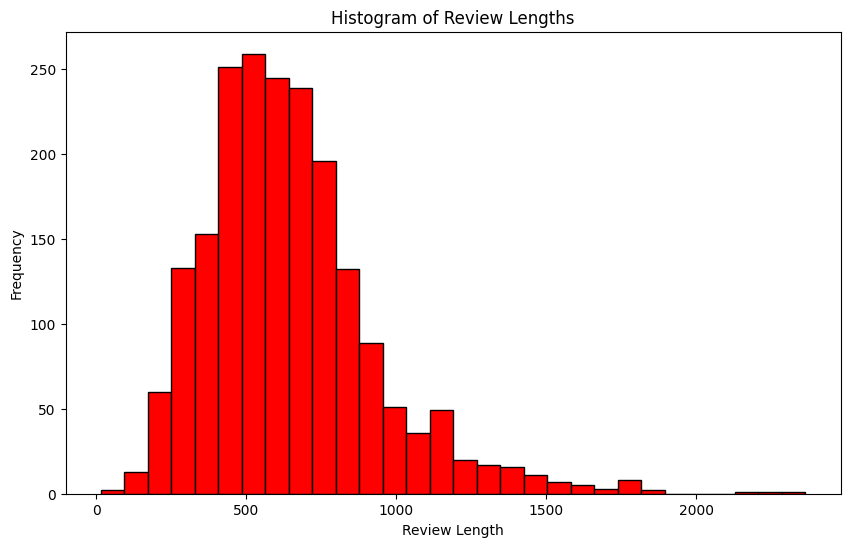

In [20]:
plt.figure(figsize=(10, 6))
plt.hist(review_lengths, bins=30, color='red', edgecolor='black')
plt.title('Histogram of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')

## To represent each text (= data point), there are many ways. In NLP/Deep Learning terminology, this task is called tokenization. It is common to represent text using popularity/ rank of words in text. The most common wordin the text will be represented as 1, the second most common word will be represented as 2, etc. Tokenize each text document using this method.

In [21]:
tokenizer = Tokenizer(num_words=10000)  
all_texts = all_data["text"]
tokenizer.fit_on_texts(all_texts)
sequences = tokenizer.texts_to_sequences(all_texts)
word_index = tokenizer.word_index
print("Word Index:", {k: word_index[k] for k in list(word_index)[:10]})
print(len(word_index))

Word Index: {'the': 1, 'a': 2, 'and': 3, 'of': 4, 'to': 5, 'is': 6, 'in': 7, 'that': 8, 'it': 9, 'as': 10}
46737


## Select a review length L that 70% of the reviews have a length below it

In [22]:
L = np.percentile(review_lengths, 70)
print("Review length L such that 70% of the reviews are shorter than this length:", L)

Review length L such that 70% of the reviews are shorter than this length: 737.0


## Truncate reviews longer than L words and zero-pad reviews shorter than L so that all texts (= data points) are of length L

In [23]:

max_words = 5000

tokenizer = Tokenizer(num_words = max_words)

all_texts = pd.concat([df_train['text'], df_test['text']])  # Combine all text data
tokenizer.fit_on_texts(all_texts)

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(df_train['text'])
test_sequences = tokenizer.texts_to_sequences(df_test['text'])

train_padded_sequences = pad_sequences(train_sequences, maxlen=737, padding='post', truncating='post')
test_padded_sequences = pad_sequences(test_sequences, maxlen=737, padding='post', truncating='post')



In [24]:
train_padded_sequences.shape

(1400, 737)

In [25]:
test_padded_sequences.shape

(600, 737)

## Word Embeddings and Multi-Layer Perceptron

In [26]:
max_len = 737
input_layer = Input(shape=(max_len,))
embedding = Embedding(input_dim=max_words, output_dim=32, input_shape=(max_len,))(input_layer)
flatten = Flatten()(embedding)
model = Model(inputs=input_layer, outputs=flatten)

In [27]:
y = model.predict(train_padded_sequences)
y.shape

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


(1400, 23584)

In [28]:
train_embedding_outputs = model.predict(train_padded_sequences)
test_embedding_outputs = model.predict(test_padded_sequences)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step


In [29]:
train_embedding_outputs.shape

(1400, 23584)

In [30]:
mlp_model = Sequential([
        Dense(50, activation='relu', input_shape=(23584,)),
        Dropout(0.2),
        Dense(50, activation='relu'),
        Dropout(0.5),
        Dense(50, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
mlp_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
mlp_model.summary()
history = mlp_model.fit(train_embedding_outputs, df_train['sentiment'], epochs=2, batch_size=10, verbose=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │     1,179,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,184,401 (4.52 MB)

 Trainable params: 1,184,401 (4.52 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5050 - loss: 0.7025
Epoch 2/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5383 - loss: 0.6902


In [32]:
train_loss, train_accuracy = mlp_model.evaluate(train_embedding_outputs, df_train["sentiment"], verbose=0)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")

test_loss, test_accuracy = mlp_model.evaluate(test_embedding_outputs, df_test["sentiment"], verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Train Accuracy: 65.07%
Test Accuracy: 54.83%


## One-Dimensional Convolutional Neural Network

In [33]:
def create_mlp_model(input_shape):
    model = Sequential([
        Dense(50, activation='relu', input_shape=(input_shape,)),
        Dropout(0.2),
        Dense(50, activation='relu'),
        Dropout(0.5),
        Dense(50, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense

def create_cnn_model(max_words, max_len, embedding_dim=32):
    model = Sequential()
    model.add(Input(shape=(max_len,))) 
    model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu',padding='same'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Flatten())
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

max_words = 5000
max_len = 737
embedding_dim = 32

cnn_model = create_cnn_model(max_words, max_len, embedding_dim)

cnn_model.summary()

train_cnn_embedding_outputs = cnn_model.predict(train_padded_sequences)
test_cnn_embedding_outputs = cnn_model.predict(test_padded_sequences)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 737, 32)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 737, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 368, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 11776)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 163,104 (637.12 KB)

 Trainable params: 163,104 (637.12 KB)

 Non-trainable params: 0 (0.00 B)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [35]:
mlp_model_2 = create_mlp_model(train_cnn_embedding_outputs.shape[1])
mlp_model_2.summary()
history_2 = mlp_model_2.fit(train_cnn_embedding_outputs, df_train['sentiment'], epochs=2, batch_size=10, verbose=1)
train_loss, train_accuracy = mlp_model_2.evaluate(train_cnn_embedding_outputs, df_train["sentiment"], verbose=0)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")


test_loss, test_accuracy = mlp_model_2.evaluate(test_cnn_embedding_outputs, df_test["sentiment"], verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 50)             │       588,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 594,001 (2.27 MB)

 Trainable params: 594,001 (2.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5479 - loss: 0.7099
Epoch 2/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5102 - loss: 0.6940
Train Accuracy: 56.50%
Test Accuracy: 54.83%


## Long Short-Term Memory Recurrent Neural Network


In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

def create_lstm_model(vocabulary_size, max_length, embedding_dim=32):
    model = Sequential([
        Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=max_length),
        LSTM(256, return_sequences=False, dropout=0.2),       
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

vocabulary_size = 5000 
max_length = 737
embedding_dim = 32

lstm_model = create_lstm_model(vocabulary_size, max_length, embedding_dim)


In [28]:
history = lstm_model.fit(train_padded_sequences, df_train['sentiment'], 
    epochs=50,
    batch_size=10,
    validation_data=(test_padded_sequences, df_test['sentiment'])
)

Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 49s 343ms/step - accuracy: 0.5183 - loss: 0.6949 - val_accuracy: 0.5000 - val_loss: 0.6919
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 43s 305ms/step - accuracy: 0.5232 - loss: 0.6951 - val_accuracy: 0.4950 - val_loss: 0.6963
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 43s 305ms/step - accuracy: 0.5286 - loss: 0.6859 - val_accuracy: 0.5417 - val_loss: 0.6925
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 42s 303ms/step - accuracy: 0.5719 - loss: 0.6436 - val_accuracy: 0.5267 - val_loss: 0.7202
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 43s 305ms/step - accuracy: 0.5925 - loss: 0.6102 - val_accuracy: 0.5267 - val_loss: 0.7696
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 43s 305ms/step - accuracy: 0.6225 - loss: 0.5994 - val_accuracy: 0.5283 - val_loss: 0.8152
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 43s 304ms/step - accuracy: 0.6032 - loss: 0.5954 - val_accuracy: 0.5017 - val_loss: 0.7293
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 43s 310ms/step - accuracy: 0.5292 - loss: 0

In [29]:
test_loss, test_accuracy = lstm_model.evaluate(test_padded_sequences, df_test['sentiment'])
print(f' Test Accuracy: {test_accuracy*100:.2f}%')

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 0.3054 - loss: 1.0157
 Test Accuracy: 52.33%


In [30]:
train_loss, train_accuracy = lstm_model.evaluate(train_padded_sequences, df_train['sentiment'])
print(f'Train Accuracy: {train_accuracy*100:.2f}%')

44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - accuracy: 0.3697 - loss: 0.5617
Train Accuracy: 61.79%
